In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.linear_model import LinearRegression, ElasticNet

folder = r"E:\GoogleDrive\NYU_MathFin\3rd_semester\DS_in_Finance\Project\dataset\\"

In [2]:
all_data = pd.read_csv(folder + r"Predictors.csv", index_col = 0, parse_dates = True)
y_data = all_data['SPX'].copy()
y_data = y_data.pct_change(130).shift(-130)
x_data = all_data.copy()
del x_data['SPX']
print all_data.isnull().any()
print type(all_data.index[0])

CAY         False
NOS         False
BM          False
PE          False
CAPE        False
DP          False
PCAprice    False
CPI         False
SPX         False
BY          False
DEF         False
TERM        False
VRP          True
IC           True
BDI         False
PCR          True
MA          False
PCAtech     False
OIL         False
SI           True
SIM         False
dtype: bool
<class 'pandas._libs.tslib.Timestamp'>


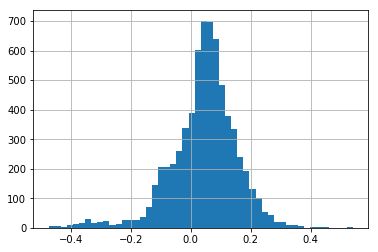

In [3]:
y_data.hist(bins = 50)

In [28]:
class VariableSelector(object):
    def __init__(self, X,Y,                  
                 **kwargs):
        self.X = X
        self.Y = Y
        self.xnames = X.columns.values
        self.X_trans = self.X.copy()
        self.model = LinearRegression()
        self.xusednames = self.xnames
        self.transMethods = None
        self.dataInventDateInfo = pd.read_csv(folder + r'DATE.csv', index_col = 0, parse_dates = [0,1,2,3])
        self.useTransformation = kwargs.get('useTransformation') or False #useTransformation
    def __setTransformForOne(self, col,
                             X_ewma_all,
                             X_log_all,
                            ):
        if np.isnan(self.X[col][0]):
            # If the first value of this column is nan, that means this data doesn't exist yet
            del self.X_trans[col]
            return 'discard',np.nan
        elif not self.useTransformation:
            self.X_trans[col] = self.X[col]     
            return 'raw', abs(np.corrcoef(self.X_trans[col], self.Y)[1,0])
        else:
            tmp = self.X[[col]].copy()
            tmp.columns = ['raw']
            this_log = X_log_all[col]
            if True:#np.isnan(this_log.any()) or not np.isfinite(this_log.all()):
                # If there's any nan, that mean original data has negative values, so
                # we cannot use log
                transMethod = ['raw','ewma']
                
            else:
                transMethod = ['raw','ewma', 'log']
                tmp['log'] = X_log_all.loc[tmp.index, col]
            tmp['ewma'] = X_ewma_all.loc[tmp.index, col]
            tmp['sp_lag'] = self.Y.copy()
            corr = tmp.corr().as_matrix()[-1,:-1]
            corr_abs = abs(corr)
            chosen = transMethod[np.argmax(corr_abs)]
            self.X_trans[col] = tmp[chosen]
            return chosen, np.max(corr_abs)
    
    def selectVariables(self, 
                        X_ewma_all = None,
                        X_log_all = None
                        ):
        transMethods = {}
        corrCoefs = {}
        for col in self.xnames:
            thisMethod, thisCorr = self.__setTransformForOne(col,
                                                            X_ewma_all,
                                                            X_log_all)
            transMethods[col] = thisMethod
            corrCoefs[col] = thisCorr

        self.transMethods = transMethods
        self.corrCoefs = corrCoefs
        self.Y = self.Y.fillna(0)##########
        
    def transformOutSample(self, 
                           outSampleX,
                           X_ewma_all,
                           X_log_all):
        outSampleX_trans = outSampleX.copy()
        for key,value in self.transMethods.items():
            if value == 'raw':
                continue
            elif value == 'discard':
                del outSampleX_trans[key]
            elif value == 'log':
                outSampleX_trans[key] = X_log_all.loc[outSampleX_trans.index, key]
            elif value =='ewma':
                outSampleX_trans[key] = X_ewma_all.loc[outSampleX_trans.index,key]#pd.ewma(outSampleX[key], alpha = 0.94)
            
        return outSampleX_trans

In [29]:
class corrSelector(VariableSelector):
    def __init__(self, X, Y, **kwargs):
        super(corrSelector, self).__init__(X, Y, **kwargs)
        self.threshold = kwargs.get('threshold') or 0.1  
    def selectVariables(self,
                        X_ewma_all = None,
                        X_log_all = None
                        ):
        super(corrSelector, self).selectVariables()
        for key, value in self.corrCoefs.items():
            if value < self.threshold:
                self.transMethods[key] = 'discard'
                del self.X_trans[key]

    def transformOutSample(self, 
                          outSampleX,
                          X_ewma_all = None,
                          X_log_all = None
                          ):
        outSampleX_trans = super(corrSelector, self).transformOutSample(outSampleX,
                                                                        X_ewma_all = X_ewma_all,
                                                                        X_log_all = X_log_all)
        for key,value in self.transMethods.items():
            if value == 'discard' and key in outSampleX_trans.columns:
                del outSampleX_trans[key]
        return outSampleX_trans    

In [30]:
class realTimeCorrSelector(corrSelector):
    def __init__(self, X, Y, **kwargs):
        super(realTimeCorrSelector, self).__init__(X, Y, **kwargs)
    
    def selectVariables(self,
                        X_ewma_all = None,
                        X_log_all = None
                        ):
        super(realTimeCorrSelector, self).selectVariables(X_ewma_all = X_ewma_all,
                                                        X_log_all = X_log_all
                                                        )
        for key, value in self.transMethods.items():
            if self.dataInventDateInfo['discover date'][key] >= self.X.index[0]:
                self.transMethods[key] ='discard'
                if key in self.X_trans.columns:
                    del self.X_trans[key]                     

In [31]:
class ReturnPredictor(object):
    def __init__(self, X, Y, 
                 firstTestDay = datetime.datetime(2000, 1, 1), 
                 Selector = VariableSelector, 
                 model = LinearRegression(),
                 **kwargs
                ):
        self.X = X
        self.X_ewma = pd.ewma(self.X, alpha = 0.94)
        self.X_log = self.X.apply(np.log)
        self.X_log -= self.X_log.rolling(20).mean()
        self.Y = Y
        self.Y_fit  = self.Y.copy() * 0.0
        self.Y_pred = self.Y.copy() * 0.0
        self.firstTestDay = firstTestDay
        self.__setSampleScope(trainset_endday = self.firstTestDay)
        self.Selector = Selector
        self.selectorParams = kwargs
        self.model = model
        
        
    def __setSampleScope(self, trainset_startday = None, trainset_endday = None):
        if trainset_startday:
            self.trainset_startday = trainset_startday
            self.trainset_endday = datetime.datetime(self.trainset_startday.year + 10, 
                                                 self.trainset_startday.month, 
                                                 1)
        elif trainset_endday:
            self.trainset_endday = trainset_endday
            self.trainset_startday = datetime.datetime(self.trainset_endday.year - 10, 
                                                   self.trainset_endday.month, 
                                                   1)
        self.insample_X = self.X[(self.X.index >= self.trainset_startday) & (self.X.index < self.trainset_endday)]
        self.insample_Y = self.Y[(self.Y.index >= self.trainset_startday) & (self.Y.index < self.trainset_endday)]
        if self.trainset_endday.month == 12:
            self.testset_endday = datetime.datetime(self.trainset_endday.year + 1, 1, 1)
        else:
            self.testset_endday = datetime.datetime(self.trainset_endday.year, self.trainset_endday.month + 1, 1)
        self.outsample_X = self.X[(self.X.index >= self.trainset_endday) & (self.X.index <= self.testset_endday)]
        self.outsample_Y = self.Y[(self.Y.index >= self.trainset_endday) & (self.Y.index <= self.testset_endday)]
        
        
    def __resetSampleScope(self):
        self.__setSampleScope(trainset_endday = self.testset_endday)
        
    def fitOneSample(self):
        thisSample = self.Selector(self.insample_X, self.insample_Y, **self.selectorParams)
        thisSample.selectVariables(X_ewma_all = self.X_ewma,
                                   X_log_all = self.X_log)
        self.insampleX_trans = thisSample.X_trans            
        self.model.fit(self.insampleX_trans, self.insample_Y)
        self.outsampleX_trans = thisSample.transformOutSample(self.outsample_X,
                                                              X_ewma_all = self.X_ewma,
                                                              X_log_all = self.X_log)
        self.insampleY_fit = self.model.predict(thisSample.X_trans)
        self.outsampleY_pred = self.model.predict(self.outsampleX_trans)
        
        self.Y_fit.loc[self.insample_Y.index] = self.insampleY_fit
        self.Y_pred.loc[self.outsample_Y.index] = self.outsampleY_pred
    
    def fitAll(self, endDate = None):
        self.modelEndDate = endDate or self.X.index[-1]
        while self.testset_endday < self.modelEndDate:
            #print self.testset_endday
            self.fitOneSample()
            self.__resetSampleScope()
            
        self.Y_pred = self.Y_pred[(self.Y_pred.index >= self.firstTestDay) & (self.Y_pred.index <= self.modelEndDate)]
        
        
    def plotLastPrediction(self):
        in_tmp = self.insample_Y.to_frame().copy()
        in_tmp.columns = ['real']
        in_tmp['pred'] = self.insampleY_pred
        out_tmp = self.outsample_Y.to_frame().copy()
        out_tmp.columns = ['real']
        out_tmp['pred'] = self.outsampleY_pred
        in_tmp.plot()
        out_tmp.plot()
    
    def plotAllPrediction(self, showFittedLine = False):
        tmp = self.Y.to_frame().copy()
        tmp.columns = ['real']
        tmp = tmp[tmp.index >= self.firstTestDay]
        tmp['pred'] = self.Y_pred
        
        if showFittedLine:
            tmp['fit']  = self.Y_fit[self.Y_fit.index >= self.firstTestDay]
        tmp = tmp[tmp.index <= self.modelEndDate]
        tmp.plot()

In [34]:
# Because our data ends at 2017.6.30 and we use future 130-day return as y,
# we have to stop fitting the model 130 business days before the end date, so roughly 2017.1.1
endDate = datetime.datetime(2017, 1, 1)
xxx = x_data[x_data.index <= endDate]
yyy = y_data[y_data.index <= endDate]

D:\ProgramFiles\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,alpha=0.94).mean()
  if __name__ == '__main__':


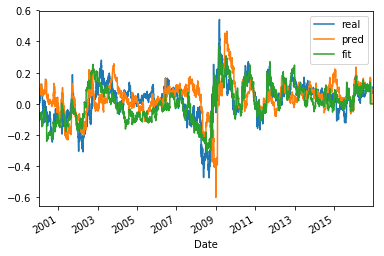

In [35]:
# Simple Linear Regression
model1 = ReturnPredictor(xxx,yyy, 
                      Selector = VariableSelector, 
                      model = LinearRegression(),
                      useTransformation = False)
model1.fitAll()
model1.plotAllPrediction(showFittedLine = True)

In [36]:
model1.Y_pred.to_csv(folder + "PredReturn_simpLR.csv")

D:\ProgramFiles\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,alpha=0.94).mean()
  if __name__ == '__main__':


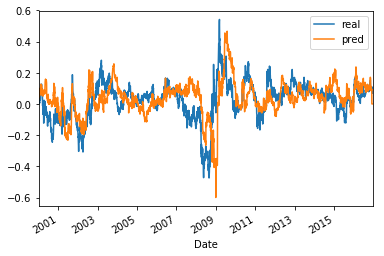

In [37]:
# Simple Linear Regression with transformation
model2 = ReturnPredictor(xxx,yyy, 
                      Selector = VariableSelector, 
                      model = LinearRegression(),
                      useTransformation = True)
model2.fitAll()
model2.plotAllPrediction()

In [38]:
model2.Y_pred.to_csv(folder + "PredReturn_LR_Trans.csv")

D:\ProgramFiles\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,alpha=0.94).mean()
  if __name__ == '__main__':


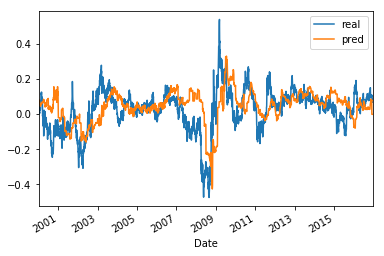

In [39]:
# Correlation screen, without transformation, for testing purpose
model3 = ReturnPredictor(xxx,yyy,
                      Selector = corrSelector, 
                      model = LinearRegression(),
                      useTransformation = False,
                      threshold = 0.2
                     )
model3.fitAll()
model3.plotAllPrediction()

In [40]:
# Correlation screen, without transformation, using different thresholds
corr_pred = pd.DataFrame()
for thres in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]:
    try:
        model3 = ReturnPredictor(xxx,yyy,
                              Selector = corrSelector, 
                              model = LinearRegression(),
                              useTransformation = False,
                              threshold = thres
                             )
        model3.fitAll()
        corr_pred['corr_' + str(thres)] = model3.Y_pred.copy()
        # model3.plotAllPrediction()
    except:
        break

D:\ProgramFiles\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,alpha=0.94).mean()
  if __name__ == '__main__':


In [41]:
corr_pred.to_csv(folder + "PredReturn_corrLR.csv", header = True)

D:\ProgramFiles\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,alpha=0.94).mean()
  if __name__ == '__main__':


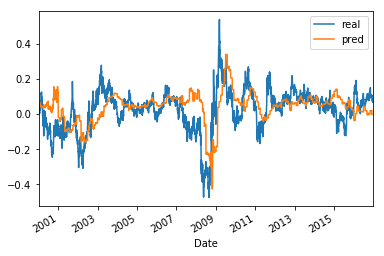

In [42]:
# Real time correlation screen, without transformation
model4 = ReturnPredictor(xxx,yyy,
                      Selector = realTimeCorrSelector, 
                      model = LinearRegression(),
                      useTransformation = False,
                      threshold = 0.2
                     )
model4.fitAll()
model4.plotAllPrediction()
#model4.Y_pred.to_csv(folder + "realCorrLR.csv")

In [43]:
# Real time correlation screen, without transformation
realCorr_pred = pd.DataFrame()
for thres in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]:
    try:
        model4 = ReturnPredictor(xxx,yyy,
                              Selector = realTimeCorrSelector, 
                              model = LinearRegression(),
                              useTransformation = False,
                              threshold = thres
                             )
        model4.fitAll()
        realCorr_pred['realCorr_' + str(thres)] = model4.Y_pred.copy()
    except:
        break

D:\ProgramFiles\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,alpha=0.94).mean()
  if __name__ == '__main__':


In [44]:
realCorr_pred.to_csv(folder + "PredReturn_realCorrLR.csv")

In [46]:
# Elastic Net regression
en_pred = pd.DataFrame()
for alpha in np.arange(1, 5)/10.0:
    for l1_ratio in np.arange(11)/10.0:
        model5 = ReturnPredictor(xxx,yyy,
                              Selector = VariableSelector, 
                              model = ElasticNet(alpha = alpha,
                                                l1_ratio = l1_ratio),
                              useTransformation = False,
                             )
        model5.fitAll()
        en_pred['en_a%s_r%s'% (str(alpha), str(l1_ratio))] = model5.Y_pred.copy()
#model5.plotAllPrediction()
en_pred.to_csv(folder + "PredReturn_elasticNet.csv")

D:\ProgramFiles\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,alpha=0.94).mean()
  if __name__ == '__main__':
